# KerasCV'de Stable Difüzyon kullanarak yüksek performanslı görüntü oluşturma


## Overview

Bu kılavuzda,  KerasCV kullanarak bir metin istemine dayalı yeni görüntülerin nasıl oluşturulacağını göstereceğim.

[stability.ai](https://stability.ai/)'nin metinden görüntüye modeli,
[Stable Diffusion](https://github.com/CompVis/stable-diffusion).

Stable Difüzyon, güçlü, açık kaynaklı bir metinden görüntüye oluşturma modelidir.Model içinde kolayca görüntüler oluşturmanıza izin veren birden fazla açık kaynak uygulaması mevcuttur.

[XLA compilation](https://www.tensorflow.org/xla) ve
[mixed precision](https://www.tensorflow.org/guide/mixed_precision) 

Bu kılavuzda, KerasCV'nin Kararlı Difüzyon uygulamasını inceleyeceğiz, nasıl kullanılacağını göstereceğiz.

Başlamadan önce keras_cv yi indirelim.

`KerasCV`, görüntü sınıflandırma gibi yaygın kullanım durumları için üretim düzeyinde, son teknoloji eğitim ve çıkarım boru hatlarını hızlı bir şekilde bir araya getirmek için bilgisayarlı görü mühendislerinin yararlanabileceği modüler yapı taşlarından (katmanlar, ölçümler, kayıplar, veri artırma) oluşan bir araç kutusudur. Nesne algılama, görüntü segmentasyonu, görüntü verisi büyütme vb.
bir çok işlemi çok hızlı şekilde yapmamıza izin verir.

In [ ]:
!pip install tensorflow keras_cv --upgrade --quiet

In [ ]:
import time
import keras_cv
from tensorflow import keras
import matplotlib.pyplot as plt

## Giriş

`keras_cv.models.StableDiffusion()` kullanacağız.

İlk olarak, bir model oluşturuyoruz.

In [ ]:
model = keras_cv.models.StableDiffusion(img_width=512, img_height=512)

Ardından, ona bir bilgi istemi veriyoruz.

50/50 [==============================] - 120s 2s/step


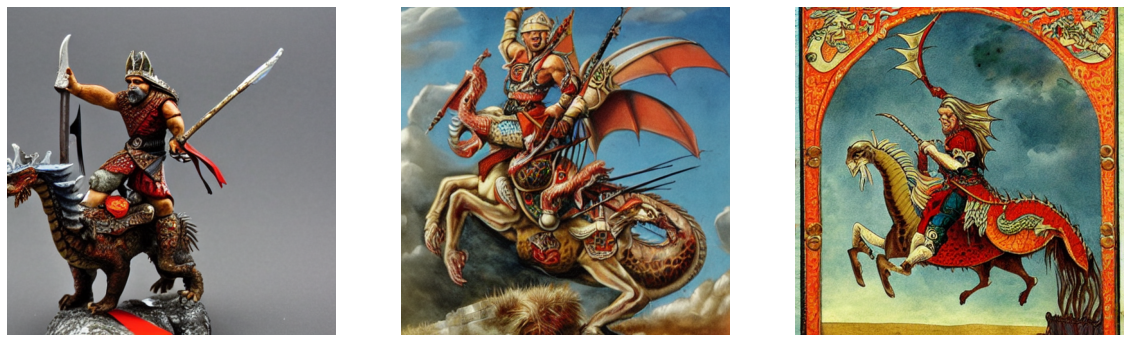

In [9]:
images = model.text_to_image("dragon-riding turkish warrior", batch_size=3)


def plot_images(images):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        plt.imshow(images[i])
        plt.axis("off")


plot_images(images)

Oldukça inanılmaz!

Ancak bu modelin yapabileceği tek şey bu değil. Daha karmaşık bir komut istemi deneyelim.

50/50 [==============================] - 121s 2s/step


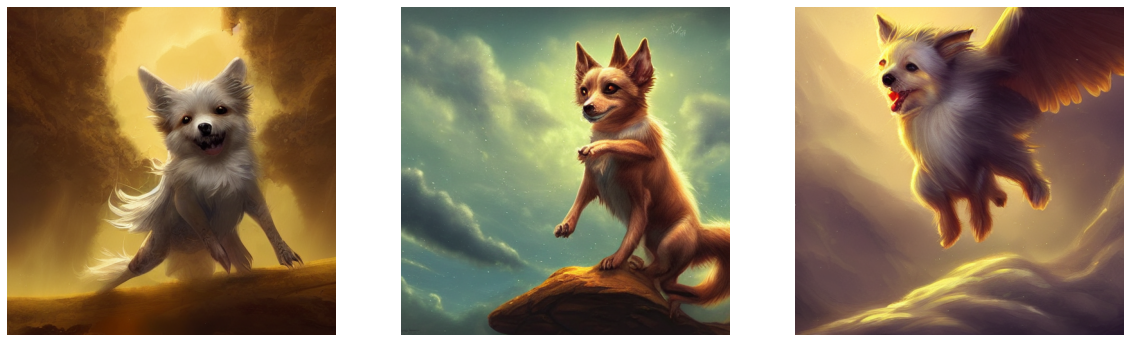

In [10]:
images = model.text_to_image(
    "cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
plot_images(images)

Olasılıklar kelimenin tam anlamıyla sonsuzdur (veya en azından kararlı difüzyonun gizli manifoldu sınırlarına kadar uzanır. :) )

## Peki, bu nasıl çalışır ? 

Bu noktada beklediğinizin aksine, StableDiffusion aslında sihirle çalışmaz:).
Bu bir tür "gizli yayılma modeli". Bunun ne anlama geldiğini inceleyelim.

Süper çözünürlük fikrini duymuş olabilirsiniz. Bir girdi görüntüsünü gürültüden arındırmak ve böylece daha yüksek çözünürlüklü bir görüntüye dönüştürmek için bir derin öğrenme modeli eğitmek mümkündür.
Süper çözünürlük ile ilgili daha fazla bilgi almak için aşağıdaki linkleri kontrol edebilirsiniz.

- [Image Super-Resolution using an Efficient Sub-Pixel CNN](https://keras.io/examples/vision/super_resolution_sub_pixel/)
- [Enhanced Deep Residual Networks for single-image super-resolution](https://keras.io/examples/vision/edsr/)

![Super-resolution](https://i.imgur.com/M0XdqOo.png)

Peki ya saf gürültü üzerinde böyle bir model çalıştırsak?. Model daha sonra "gürültüyü giderir" ve yepyeni bir görüntü halüsinasyonuna başlar. Bazen, küçük bir gürültü parçasını giderek daha net ve yüksek çözünürlüklü yapay bir resme dönüştürebilirsiniz.

Gizli difüzyonun ana fikri budur.
[High-Resolution Image Synthesis with Latent Diffusion Models](https://arxiv.org/abs/2112.10752),
[Denoising Diffusion Implicit Models](https://keras.io/examples/generative/ddim/).

![Denoising diffusion](https://i.imgur.com/FSCKtZq.gif)

Şimdi, gizli yayılmadan metinden görüntüye bir sisteme geçmek için,
yine de tek bir anahtar özellik eklemeniz gerekiyor: oluşturulan görsel içerikleri komut istemi anahtar sözcükleri aracılığıyla kontrol etme yeteneği.

Bu, klasik bir derin öğrenme tekniği olan "koşullandırma" yoluyla yapılır. Bir parça metni temsil eden bir vektör, ardından modeli {image: caption} çiftlerinden oluşan bir veri kümesi üzerinde eğitiyor.

Bu, Kararlı Difüzyon mimarisine yol açar. Kararlı Difüzyon üç bölümden oluşur:

- İsteminizi gizli bir vektöre dönüştüren bir metin kodlayıcı.
- Bir 64x64 gizli görüntü yamasını tekrar tekrar "gürültüden arındıran" bir difüzyon modeli.
- Son 64x64 gizli yamayı daha yüksek çözünürlüklü 512x512 görüntüye dönüştüren bir kod çözücü.

İlk olarak, metin isteminiz ( yani girilen cümle ) metin kodlayıcı tarafından gizli bir vektör uzayına yansıtılır,
bu sadece önceden eğitilmiş bir dil modeli aracılığıyla yapılır. Sonra bu bilgi istemi vektörü bir dizi boyunca difüzyon modeli tarafından tekrar tekrar "gürültüden arındırılan" rastgele oluşturulmuş bir gürültü yamasıyla birleştirilir.
(ne kadar çok adım çalıştırırsanız görüntünüz o kadar net ve güzel olur -- varsayılan değer 50 adımdır).

Son olarak, 64x64 gizli görüntü, yüksek çözünürlükte düzgün bir şekilde işlenmesi için kod çözücü aracılığıyla gönderilir.

![The Stable Diffusion architecture](https://i.imgur.com/2uC8rYJ.png)

- [text_encoder.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/text_encoder.py): 87 LOC
- [diffusion_model.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/diffusion_model.py): 181 LOC
- [decoder.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/decoder.py): 86 LOC
- [stable_diffusion.py](https://github.com/keras-team/keras-cv/blob/master/keras_cv/models/stable_diffusion/stable_diffusion.py): 106 LOC

Bu görece basit sistem, milyarlarca resim ve bunların altyazıları üzerinde çalıştığınızda sihir gibi görünmeye başlar.
Feynman'ın evren hakkında dediği gibi: _"Karmaşık değil, sadece çok fazla!"_

## KerasCV'nin Avantajları

`keras_cv.models.StableDiffusion` neden kullanmalıyız?

- Grafik modu yürütme,
- XLA derlemesi aracılığıyla derleme `jit_compile=True` yaparak,
- Karışık hassas hesaplama desteği

Şimdi parametreler değiştiğinde nelerden kazanç nelerden kayıp yaşadığımızı anlamak adına karşılaştırmalar yapalım.

Başlamak için önce optimize edilmemiş modelimizi karşılaştıralım:

50/50 [==============================] - 119s 2s/step
Standard model: 121.21 seconds


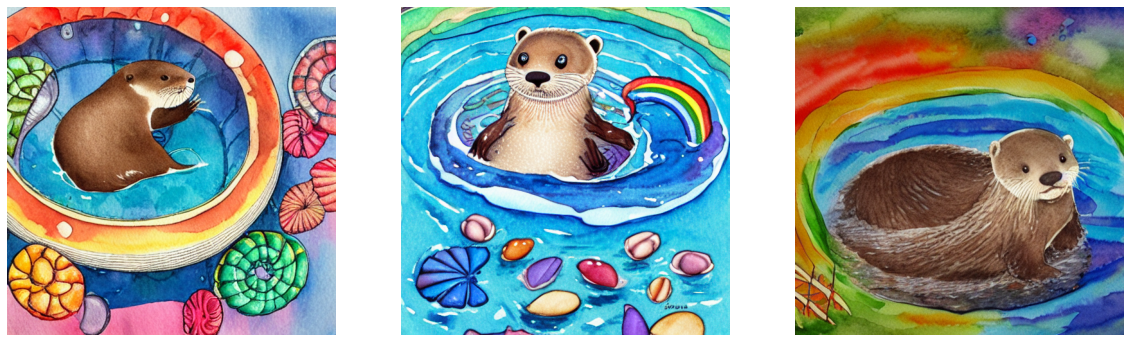

In [11]:
benchmark_result = []
start = time.time()
images = model.text_to_image(
    "A cute otter in a rainbow whirlpool holding shells, watercolor",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Standard", end - start])
plot_images(images)

print(f"Standart model: {(end - start):.2f} seconds")
keras.backend.clear_session()  # belleği korumak için oturumu temizleyin.

### Karışık hassasiyet

`Mixed precision` "float16" kullanarak hesaplama yapmaktan oluşur
ağırlıkları "float32" biçiminde hassasiyet ile saklar. Bunun nedeni NVIDIA GPU'larının da float32 olarak işlem yapmasıdır. Bu durum bize hız kazandırır.

Keras'ta bunu etkinleştirmek için ;

In [12]:
keras.mixed_precision.set_global_policy("mixed_float16")

In [13]:
model = keras_cv.models.StableDiffusion()

print("İşlem türü:", model.diffusion_model.compute_dtype)
print(
    "değişken tipi:",
    model.diffusion_model.variable_dtype,
)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE
İşlem türü: float16
değişken tipi: float32


Gördüğünüz gibi, yukarıda oluşturulan model artık karışık kesinlikli hesaplama kullanıyor; değişkenleri `float32` hassasiyetinde saklarken, hesaplama için `float16` işlemlerinin hızından yararlanır.

50/50 [==============================] - 60s 1s/step
Karışık hassas model: 61.04 seconds


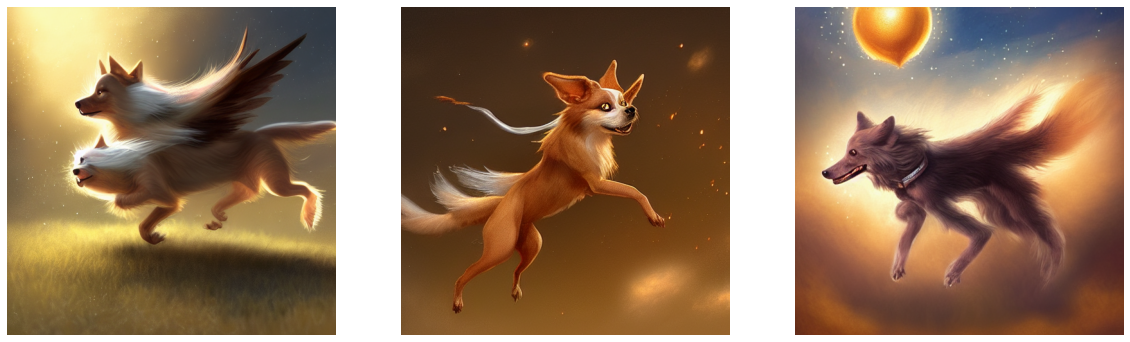

In [14]:
model.text_to_image("warming up the model", batch_size=3)

start = time.time()
images = model.text_to_image(
    "a cute magical flying dog, fantasy art, "
    "golden color, high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting, mystery, adventure",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["Mixed Precision", end - start])
plot_images(images)

print(f"Karışık hassas model: {(end - start):.2f} seconds")
keras.backend.clear_session()

### XLA Derleme

TensorFlow şunu destekler:-->
[XLA: Accelerated Linear Algebra](https://www.tensorflow.org/xla) adındaki yerleşik derleyici.
`keras_cv.models.StableDiffusion` içinde `jit_compile` argümanını True ayarlamamız yeterli olacaktır.

In [ ]:
# Kıyaslama amaçları için varsayılana geri ayarlayın.
keras.mixed_precision.set_global_policy("float32")

model = keras_cv.models.StableDiffusion(jit_compile=True)
# Modeli kıyaslamadan önce, TensorFlow'un olduğundan emin olmak için bir kez çıkarım yaparız.
images = model.text_to_image("An avocado armchair", batch_size=3)
plot_images(images)

XLA modelimizi kıyaslayalım:

In [ ]:
start = time.time()
images = model.text_to_image(
    "A cute otter in a rainbow whirlpool holding shells, watercolor",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA", end - start])
plot_images(images)

print(f"XLA ile birlikte: {(end - start):.2f} seconds")
keras.backend.clear_session()

## Hepsi birlikte.

Peki, dünyanın en performanslı kararlı difüzyon çıkarımını nasıl bir araya getirirsiniz? ( bu gelişme 2022 yılından sonra gerçekleşti )

Bu iki kod satırı ile:)

In [21]:
keras.mixed_precision.set_global_policy("mixed_float16")
model = keras_cv.models.StableDiffusion(jit_compile=True)

By using this model checkpoint, you acknowledge that its usage is subject to the terms of the CreativeML Open RAIL-M license at https://raw.githubusercontent.com/CompVis/stable-diffusion/main/LICENSE


Ve onu kullanmak için...

In [ ]:
images = model.text_to_image(
    "Teddy bears conducting machine learning research",
    batch_size=3,
)
plot_images(images)

In [ ]:
start = time.time()
images = model.text_to_image(
    "A mysterious dark stranger visits the great pyramids of egypt, "
    "high quality, highly detailed, elegant, sharp focus, "
    "concept art, character concepts, digital painting",
    batch_size=3,
)
end = time.time()
benchmark_result.append(["XLA + Mixed Precision", end - start])
plot_images(images)

print(f"XLA + mixed precision: {(end - start):.2f} seconds")

Sonuçları kontrol edelim:

In [ ]:
print("{:<22} {:<22}".format("Model", "Runtime"))
for result in benchmark_result:
    name, runtime = result
    print("{:<22} {:<22}".format(name, runtime))